8장. 컨볼루션을 활용한 일반화

8.2

In [33]:
#이전 코드 불러오기
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)





class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']



from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))



cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))




label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]





connected_model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))




numel_list = [p.numel()
              for p in connected_model.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list





first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))





numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list






linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

Files already downloaded and verified


Files already downloaded and verified


(torch.Size([1024, 3072]), torch.Size([1024]))

In [34]:
conv = nn.Conv2d(3, 16, kernel_size=3) #인풋채널수, 아웃풋 채널수
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [35]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [36]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0)) #0번쨰 차원이 batch로
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

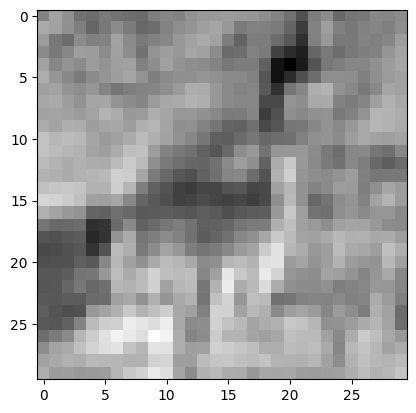

In [37]:
#텐서오옹 텐서처리된 이미지를 이미지로 출력하는거
plt.imshow(output[0,0].detach(), cmap='gray')
plt.show()

In [38]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

8.2.2 컨볼루션으로 피처 찾아내기

In [39]:
#bias 0 으로 제거
with torch.no_grad():
    conv.bias.zero_()

#가중치에 상수 넣어 출력에서의 픽셀이 이웃픽셀에 대한 평균 가지게~(by conv.weight.fill_())

with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

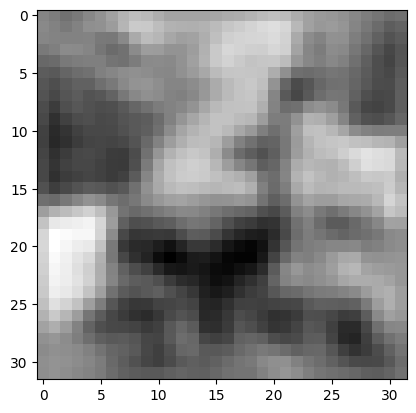

In [40]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [41]:
#커널 바꿔보기
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

8.2.3 깊이와 풀링으로 한 단계 더 인식하기
-----------

이미지 내 그림이 크면, 신경망이 패턴인식할때 '더 큰 커널 사용'
커널 넘 크면 컨볼루션 장점 사라짐
컨볼루션 쌓으면서 다운샘플링하는 방법은: 

<큰 이미지에서 작은 이미지로: 다운샘플링>

In [42]:
#맥스풀링
pool = nn.MaxPool2d(2) #이미지를 절반으로 줄임
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

8.2.4 우리의 신경망에 적용하기
----


In [43]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), #(채널수, 독립적인 피처, .., ..)
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1), #다운샘플링된 이미지, 높은 수준의 피처
            nn.Tanh(),
            nn.MaxPool2d(2),
            #
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

In [44]:
#파라미터 갯수세기
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

8.3 nn.Module 서브클래싱하기
----

8.3.1 nn.Module로 정의된 우리의 신경망

In [45]:
#Net class를 인스턴스화함. 

class Net(nn.Module):
    def __init__(self): #__int__ : 클래스 생성자
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2) ##2*2
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32) #입력크기 8*8*8, 출력크기 32
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

#순전파
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) 
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [46]:
model = Net()
model(img.unsqueeze(0))

tensor([[0.0427, 0.0202]], grad_fn=<AddmmBackward0>)

8.3.3 함수형 API
-----------


In [47]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2) #2 = 2*2 커널
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [48]:
model = Net()
model(img.unsqueeze(0))

tensor([[0.1720, 0.1507]], grad_fn=<AddmmBackward0>)

8.4 우리가 만든 컨볼루션 신경망 훈련시키기
---


In [49]:
#훈련루프 완벽 구성 단계
import datetime #날짜, 시간 연산 쉽게 수행하는 기본 라이브러리

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader): #인자 다섯개~~
    for epoch in range(1, n_epochs + 1):  
        loss_train = 0.0 #변수 초기화
        for imgs, labels in train_loader:  
            
            outputs = model(imgs) #model에 이미지 전달
            
            loss = loss_fn(outputs, labels)  

            optimizer.zero_grad()  #옵티마이저의 그래디언트 0으로 초기화
            
            loss.backward()  #손실의 그래디언트 계산
            
            optimizer.step() #옵티마이저로 매개변수 업데이트

            loss_train += loss.item()  #현재 미니배치의 손실을 loss_train변수에 더함. / .item(): 텐서 to 스칼라

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader))) 

In [50]:
#정의 후 training_loop로 모델 학습
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)  # DataLoader 클래스

model = Net()  #위에서 정의한거
optimizer = optim.SGD(model.parameters(), lr=1e-2)  #학습률 0.01
loss_fn = nn.CrossEntropyLoss()   

training_loop(  
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
##이건 손실값으로 정확도 측정한거고

2024-04-05 09:32:35.308198 Epoch 1, Training loss 0.5790962628118551
2024-04-05 09:33:18.802368 Epoch 10, Training loss 0.32671168285190677
2024-04-05 09:34:00.566184 Epoch 20, Training loss 0.2928355387441672
2024-04-05 09:34:47.509333 Epoch 30, Training loss 0.2706265791681162
2024-04-05 09:35:18.131595 Epoch 40, Training loss 0.2548033180320339
2024-04-05 09:35:50.679917 Epoch 50, Training loss 0.23745034720487657
2024-04-05 09:36:25.255780 Epoch 60, Training loss 0.22348935593655156
2024-04-05 09:37:00.579051 Epoch 70, Training loss 0.2088231583404693
2024-04-05 09:37:33.877013 Epoch 80, Training loss 0.1915418425942682
2024-04-05 09:38:08.980566 Epoch 90, Training loss 0.17861243546198888
2024-04-05 09:38:42.164270 Epoch 100, Training loss 0.16461306530389058


8.4.1 정확도 측정
----

In [51]:
#손실값보다 해석하기 좋은 정확도 측정법
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]: 
        correct = 0
        total = 0

        with torch.no_grad(): 
            for imgs, labels in loader: #배치단위로 이미지, 레이블 가져옴
                outputs = model(imgs) 
                _, predicted = torch.max(outputs, dim=1) #_: 최대값 자체 / predicted : 예측된 클래스(=최대값의 인덱스)
                total += labels.shape[0]  #현재 배치에 있는 이미지 갯수 추가(for총 처리 갯수 추적)
                correct += int((predicted == labels).sum())  #== 불리언 / 맞는거 .sum으로 계산/int로 정수로 변환해 갯수 계산

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.89
Accuracy val: 0.85


8.4.2 모델을 저장하고 불러오기
------

In [52]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [53]:
loaded_model = Net() 
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

8.4.3 GPU에서 훈련시키기
----

In [54]:
import torch
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [55]:
torch.cuda.is_available()

True

In [56]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 4050 Laptop GPU'

8.5.1 메모리 용량 늘리기: 너비
---------

In [57]:
class NetWidth(nn.Module):
    def __init__(self): #클래스의 초기화 메서드
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) #(입력채널, 출력채널)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32) #(입력크기, 출력 개수)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

모델은 GPU에 있는데 데이터는 CPU에 있다는데.. 어떻게 해결하져

In [58]:
model = NetWidth().to(device=device) #GUP실행
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

validate(model, train_loader, val_loader)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
sum(p.numel() for p in model.parameters())

38386

8.5.2 모델이 수렴하고 일반화하도록 돕는 방법: 정규화
---

<가중치 패널티>

In [ ]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn,
                        train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

#손실함수에 _norm더해서 가중치 패널치 적용함. 
            l2_lambda = 0.001 #정규화 강도를 조절하는 하이퍼파라미터
            l2_norm = sum(p.pow(2.0).sum() #_norm : 모든 파라미터의 제곱합 / p.pow = p의 각 원소를 ()안의 지수로 거듭제곱
                          for p in model.parameters()) 
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()

            
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))


In [ ]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
all_acc_dict = collections.OrderedDict()
training_loop_l2reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["l2 reg"] = validate(model, train_loader, val_loader)

2024-04-02 21:25:32.142205 Epoch 1, Training loss 0.6198746459499286
2024-04-02 21:25:40.892631 Epoch 10, Training loss 0.3628305968395464
2024-04-02 21:25:50.716108 Epoch 20, Training loss 0.32362234905646864
2024-04-02 21:26:00.434486 Epoch 30, Training loss 0.2992090948258236
2024-04-02 21:26:10.580536 Epoch 40, Training loss 0.28116252695678906
2024-04-02 21:26:20.977945 Epoch 50, Training loss 0.26707421727241226
2024-04-02 21:26:31.216001 Epoch 60, Training loss 0.25404627929637386
2024-04-02 21:26:41.670726 Epoch 70, Training loss 0.24203938117642312
2024-04-02 21:26:51.756573 Epoch 80, Training loss 0.23109726152222626
2024-04-02 21:27:01.956099 Epoch 90, Training loss 0.22129109535057834
2024-04-02 21:27:12.198106 Epoch 100, Training loss 0.21251973580972405
Accuracy train: 0.91
Accuracy val: 0.88


<드랍아웃>: 훈련 반복할떄마다 신경망의 뉴런 출력을 랜덤하게 0으로 만드는것 _ 오버피팅 방지

In [ ]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4) #40%확률로 픽셀이 드롭아웃됨(학습중에만)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4) 
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2) #view : 텐서 모양 변경 
        #-1: 첫번째 차원. 텐서의 총 요소 수 유지하면서 다른 차원 크기에 따라 첫번째 차원의 크기를 자동으로 조정)
        # 8 * 8 * self.n_chans1 / 2: 두번쨰 차원의 크기. self.n_chans1 : 채널수 / //2 : 결과를 2로 나눔
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

<배치 정규화>


In [ ]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__() #super() : 승계
        self.n_chans1 = n_chans1 
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1) #정규화 모듈 :batchnormwd ~~
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, 
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out